# Intro to Machine Learning
We're going to be working with CAP imagery for the second half of this week. Recall the two main guiding questions for this week:
- _What_ is in an image (e.g. debris, buildings, etc.)?
- _Where_ are these things located _in 3D space_ ?

## Motivation

We've already seen how structure from motion can begin to answer the second of those questions, at least in a coarse manner. The first question is more difficult than the second for one crucial reason: it (so far) can not be answered *solely* using image data. Recall that structure from motion was able to leverage image metadata, features and geometric constraints without having to insert any "outside" data. When detecting the components of an image, there is a certain amount of subjectivity that so far requires human input. For example, if you want to detect flooding in an image, there need to be some set of rules that the software can determine "if (rules are satisfied), then (flooding = True)".

How can you start to tackle this problem? We're going to make the problem a bit simpler by turning it into a classification problem rather than a localization problem. That is, instead of finding where flooding is in an image, we'll find whether there is flooding at all. With that in mind, let's first try a naive approach and see if we can simply enumerate the rules. Let's look at some flooding images:

<img src="notebook_images/010_1282_99809b0c-fc64-46e5-957f-7ff8e7547d8c.jpg" width="500"  />

<img src="notebook_images/DSC_0655_0cbbe7e5-be24-4274-bf5a-664c6f2dc3e1.jpg" width="500"  />

So what do we see? It looks like flooding is this murky, brown color that covers most of the image. So let's make a rule: if some percentage of the image is this brownish color (you can think of detecting this by creating some sort of index, like you did with the satellite imagery), there is flooding in the image. This might work for the two images we saw, but the real test is seeing if it works with other images. So let's look at another one:

<img src="notebook_images/DSC_8218_7bb15c80-481b-411a-a54a-a36e9d8b6098.jpg" width="500"  />

This image has a large percentage of it covered by brownish looking water. However, it's clearly not flooding, but rather just a lake. No problem, let's just make another rule: if some percentage of the image is this brownish color *and* there are also lots of buildings (let's also make an index for that), there is flooding in the image. Let's see if this works:

<img src="notebook_images/DSC_8192_fe6812cd-c985-4e59-a62c-04a883ec42cc.jpg" width="500"  />

Again, this is just some lake (the same lake as before, in fact). At this point, we might be thinking of shifting our strategy a bit. Clearly having someone sit down and enumerate all of the rules is impractical in this case\*. There is simply too much variability in the images to come up with a set of rules that is remotely generalizable. 

This is one of the major motivations of machine learning. The idea is that, rather than enumerate the rules that determine flooding, we're going to just enumerate the outcomes (e.g. whether there is flooding or not) and develop algorithms for the computer to *learn* what the rules are. There is a rich literature (and a host of undergraduate and graduate courses) on how these algorithms are designed, but on these next couple of days we will instead focus on how to interpret and implement them. 

\* This isn't to say that enumerating the rules isn't practical in *every* case. It really depends on the characteristics of the data. 

## A simple case study

We're going to start with a simple dataset. We will use the  Breast Cancer Wisconsin (Diagnostic) Data Set (https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)), a dataset that shows whether a tumor is benign or malign and various other features. 

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
import re # regular expressions, part of standard python library

# read the dataframe
df = load_breast_cancer(return_X_y=False, as_frame=True)["data"]
df["target"] = load_breast_cancer(return_X_y=False, as_frame=True)["target"] # benign is 1, malign is 0
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


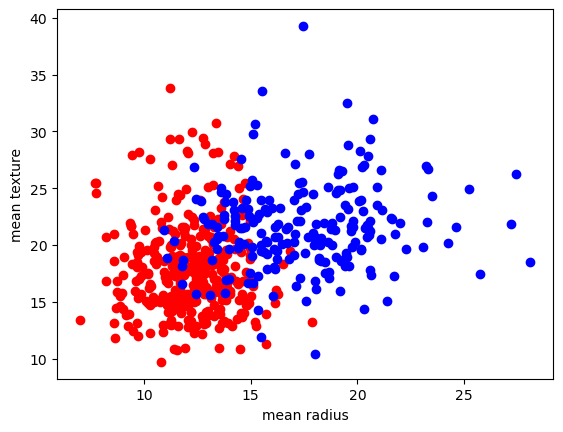

In [3]:
# for now we're just going to focus on mean radius and mean texture.
# we'll plot one against the other, and color code depending on survival
df_b = df[df["target"] == 1]
df_m = df[df["target"] == 0]

# plotting
plt.plot(df_b["mean radius"], df_b["mean texture"], "ro")
plt.plot(df_m["mean radius"], df_m["mean texture"], "bo")
plt.xlabel("mean radius")
plt.ylabel("mean texture")
plt.show()

So what do we see? Clearly there are factors beyond the ones plotted that explain whether a tumor is benign. However, it's not difficult to see a pattern here. The further up and to the right you are, the less likely you are to survive. So as a first attempt, we will have the software learn a *linear classifier*. This classifier will be a line that will classify you as benign if you are below the line, and malign otherwise. 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.7 MB/s eta 0:00:00a 0:00:01
[[-0.65045337 -0.1590059 ]]


/tmp/ipykernel_91/357811201.py:27: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X_train.values, y_train.values.astype(np.integer), clf=classifier, legend=2)
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


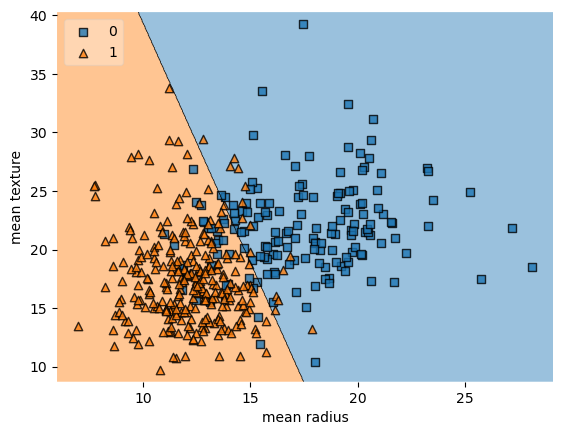

In [3]:
from sklearn import svm
from sklearn.model_selection import train_test_split
try:
    from mlxtend.plotting import plot_decision_regions
except:
    !pip install mlxtend
    from mlxtend.plotting import plot_decision_regions

# setting the features and the targets
X = df[["mean radius", "mean texture"]]
y = df["target"]

# splitting training and testing set 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize SVM classifier
classifier = svm.SVC(kernel='linear')

# Fit data
classifier = classifier.fit(X_train, y_train)

# Printing parameters
coef = classifier.coef_
print(coef)

# Plot decision boundary
plot_decision_regions(X_train.values, y_train.values.astype(np.integer), clf=classifier, legend=2)
plt.xlabel("mean radius")
plt.ylabel("mean texture")
plt.show()

There is a lot going on here, so let's try to break it down. Recall that we are trying to determine whether a patient survives using just the (normalized) age and detected nodes. These are called the explanatory variables or *features*, and we refer to it as $X$. The variable we are trying to predict is the prediction variable or *target*, and we refer to it as $y$. 

The underlying notion behind machine learning is that patterns that hold in a subset of data will hold in the population as a whole. So in a sense, we care about the performance of the classifier on data that the algorithm has *not* seen by learning patterns in that data that we have seen. To this end, one of the major paradigms in machine learning is to separate our data into a *training set* and a *testing set*. The training set is a subset of the given data that we will actually provide to the algorithm to learn, while the testing set will be used solely to report the performance on data that the algorithm has not seen. In our case, we set 80% of the data as training data and 20% as testing data.

There are numerous algorithms that can train on data. One of the more popular ones (especially before neural networks were introduced) are called *support vector machines* (SVM). We will not discuss how it actually does the learning, but suffice to say it takes in the training data and finds the line that minimizes the classification error. This line is called the *decision boundary* and it is defined by the following equation:

\begin{equation}
C_1(mean\ radius) + C_2(mean\ texture) = 0
\end{equation}

Where $C_1$ and $C_2$ are the coefficients of the linear classifier. So really, the function of the SVM is to find these two coefficients. The algorithm then does classification as follows:

\begin{equation}
y_{pred} =
\begin{cases}
    1               & \text{if } C_1(mean\ radius) + C_2(mean\ texture)\geq 0\\
    0,              & \text{otherwise}
\end{cases}
\end{equation}

### Exercise
- Look at the first 5 samples in the testing data set. Calculate the predicted target of each of the 5 samples?
- Look at the corresponding targets. Are the predictions accurate? What proportion of the predicted values are correctly predicted?
- Which of the two coefficients is most important? Why?

In [1]:
import pandas as pd

print(df.head(5))

y_pred = df['meanradius'] + df['meantexture']

for i in range(5):
    prediction = 'benign' if y_pred.iloc[i] >= 0 else 'malign'
    true_target = df['target'].iloc[i]
    print(f"Sample {i+1}: Prediction = {prediction}, True Target = {true_target}")

correct_predictions = (y_pred >= 0) == (df['target'] == 'benign')
accuracy = correct_predictions.mean()
print(f"Accuracy: {accuracy:.2f}")


NameError: name 'df' is not defined

How good is our classifier? We can look at the performance of our classifier on the testing set to find out. Of course, an important metric to look out for is the accuracy:

\begin{equation}
\text{Accuracy} = \frac{\#\ (y_{true} == y_{pred})}{\# \ \text{samples}}
\end{equation}

However, for most applications it is also worth understanding what your *false positive* and *false negative* rate is. A false positive is a sample that is classified as a 1 but is in reality a 0, and a false negative is the opposite\*. The false positive rate is defined as $\frac{\# \text{False positives}}{\# \ \text{False positives + True negatives}}$, while the false negative rate is defined as $\frac{\# \text{False negatives}}{\# \ \text{False negatives + True positives}}$. **Why would this be a metric we care about, especially in this case?**

<details>
    <summary>ANSWER</summary>
    Imagine your tumor is predicted as malignant but is in fact benign. There is certainly now a cost you incur in further tests or surgeries, but ultimately it is a manageable cost. Now imagine if you predicted a tumor as benign even thoguh it is malignant. Here, the mistake of the classifier could certainly cost you your life.
</details>

It turns out there is a useful tool called a *confusion matrix* that handily lays it out for you.

\* It's worth putting some effort into what we call positives and negatives. Here, we use the term positive to mean 1 (benign) and negative to mean 0 (malign). However, anyone that has had a test of any sort knows that positive usually means that you have the disease (in our case, malign tumor). A lot of data science is communicating results, so something worth thinking about.

0.8947368421052632


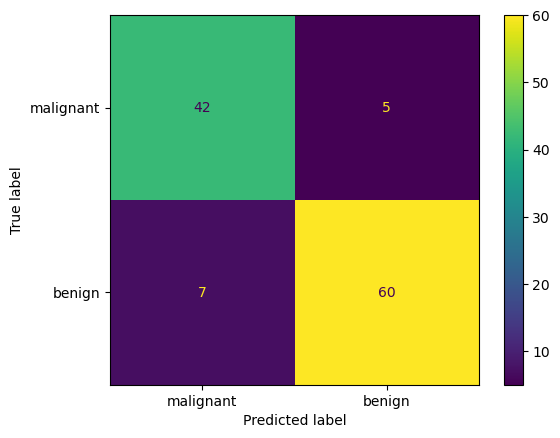

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = classifier.predict(X_test) # run prediction on test features 
accuracy = np.sum(predictions == y_test)/np.size(predictions)
print(accuracy)

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['malignant', 'benign'])

disp.plot()
plt.show()

As a final note, we used two variables (radius and texture) because it made it possible to visualize. However, there is nothing preventing us from using the rest of the data set columns as part of our features. While visualization in more than 2D is much more difficult, the underlying principles are exactly the same.

## Deep learning
So far, we've worked exclusively with linear decision boundaries. However, usually data is much more complicated (as you should have seen from the exercise). Therefore, we might want to look for something that has higher predictive power. One of the most popular tools in machine learning has been the *neural network*. A neural network is (loosely) inspired by the way neurons are connected and operate. Let's first look at the simplest possible neural network and work our way up:

<img src="notebook_images/nn_nohidden_new.png" width="500"  />

Neural networks are made up of *layers*. In the image above, the neural network has two layers. The first layer is called the *input layer*, and the last layer is called the *output layer*. Each layer is composed of *neurons*. In the input layer, each neuron is one of the features from the training data. For example, the first neuron might be the mean radius, and the second neuron might be the mean texture. We're going to refer to each neuron by $x_{l, n}$, where $l$ is the number of the layer and $n$ is the number of the neuron within the layer. Using this notation, mean radius = $x_{1, 1}$.

Each neuron in the input layer is connected to *every* neuron in the following layer by a *weight*. We will denote each weight by $w_{l, i, o}$, where $l$ is the layer at the tail of the arrow, $i$ is the number of the neuron at the tail of the arrow and $o$ is the number of the neuron at the head of the arrow. In the figure above, the color of the arrow corresponds to the value of the weight (blue means negative, red means positive). Every neuron in subsequent layers is equal to the sum of the products of the neurons and the weight that connects them. In this case, the neuron in the output layer is defined as:

\begin{equation}
x_{2, 1} = x_{1, 1}w_{1, 1, 1} + x_{1, 2}w_{1, 2, 1}
\end{equation}

Once you have the value of the output layer, you can obtain the predicted classification by applying some function to $x_{2, 1}$. An example of such a function would be similar to what we did previously:

\begin{equation}
y_{pred} =
\begin{cases}
    1               & \text{if } x_{2, 1}\geq 0\\
    0,              & \text{otherwise}
\end{cases}
\end{equation}

So training a neural network is simply finding the weights $w$ that minimize the error. If you are keen-eyed though, you might have realized that the example above is identical to what we were doing before. Therefore, we still have not arrived at a more powerful classifier. Let's try a more complicated neural network.

<img src="notebook_images/nn_hidden_new.png" width="500"  />

This network is similar to the previous one, but now we have an additional layer in between the input and output layers. All layers that are between input and output are called *hidden layers*, though functionally they behave in exactly the same way. As a quick concept question, **what is the value of $x_{2, 3}$? What about $x_{3, 1}$?**

<details>
    <summary>ANSWER</summary>
    $x_{2, 3} = x_{1, 1}w_{1, 1, 3} + x_{1, 2}w_{1, 2, 3}$ ,  
    $x_{3, 1} = x_{2, 1}w_{2, 1, 1} + x_{2, 2}w_{2, 2, 1} + x_{2, 3}w_{2, 3, 1} + x_{2, 4}w_{2, 4, 1} + x_{2, 5}w_{2, 5, 1}$
</details>

Why are we introducing a hidden layer? Notice that each of the neurons in the hidden layer are essentially acting as linear classifiers. By having a weighted sum of these neurons in the output layer, we are arriving at a function that, by virtue of being a sum of lines is not itself linear. One of the biggest results in machine learning is that, as you increase the number of neurons in the hidden layer, you can approximate *any* function, meaning that you can always make a more powerful classifier by just adding more neurons. However, usually this is not computationally efficient. Rather, most of the time it makes more sense to introduce more hidden layers as opposed to more neurons, as shown in the image below:

<img src="notebook_images/nn_deep.png" width="500"  />

The added "depth" as a result of more layers is where the "deep" in "deep learning" comes. As computational resources have increased, scientists have increasingly resorted to adding more and more layers to their neural networks. 

### Discussion questions
Let's start thinking about the LADI dataset. We want to use deep learning to detect whether there is flooding in the image.
- Using the paradigm above, what would be the features of the dataset? What are the targets?
- Propose a way that you would input the features into a neural network?
- What problems might you run into if you directly put an image into the neural network above?

## Convolution
Convolution is a fairly old technique in image processing. Convolution works by multiplying a matrix (called a *kernel*) with portions of the image and adding up the result. An animation of how this works is shown below. The result of applying different kernels is also shown:

<img src="notebook_images/convolution_anim.gif" width="500"  />

<img src="notebook_images/convolution.png" width="500"  />

As you can see, different kernels can pick up different features depending on the specific coefficients of the kernel. In the late 1980s, scientists first thought to use neural networks to learn the kernel values themselves, which created the foundation for the *convolutional* neural network (CNN). These complement the hidden layers from the previous architecture with new convolutional layers, which perform convolution on the previous layer. In so doing, these networks conserve the relationship between nearby pixels and perform very well in image classification.

<img src="notebook_images/cnn.png" width="500"  />


## The LADI dataset
The LADI dataset contains CAP images as well as crowdsourced labels for a number of different categories. Today we're going to start the multi-day exercise of applying deep learning to the LADI dataset in order to do classification of flooding. This section borrows heavily from the following tutorial: https://github.com/LADI-Dataset/ladi-tutorial

### Data reading and cleaning
We first have to go through some work to make sure that we only have the components of the dataset that we want. 

In [7]:
# read the tsv file with the labels
ladi_responses_raw = pd.read_csv("http://ladi.s3-us-west-2.amazonaws.com/Labels/ladi_aggregated_responses_url.tsv",delimiter='\t',header='infer')
ladi_responses_raw

,url,WorkerId,Answer
0,https://ladi.s3-us-west-2.amazonaws.com/Images...,0,['damage:flood/water']
1,https://ladi.s3-us-west-2.amazonaws.com/Images...,1,['damage:flood/water']
2,https://ladi.s3-us-west-2.amazonaws.com/Images...,2,['damage:flood/water']
3,https://ladi.s3-us-west-2.amazonaws.com/Images...,20,['damage:flood/water']
4,https://ladi.s3-us-west-2.amazonaws.com/Images...,0,['damage:flood/water']
...,...,...,...
289835,https://ladi.s3-us-west-2.amazonaws.com/Images...,488,['damage:none']
289836,https://ladi.s3-us-west-2.amazonaws.com/Images...,496,['damage:none']
289837,https://ladi.s3-us-west-2.amazonaws.com/Images...,516,['damage:misc']
289838,https://ladi.s3-us-west-2.amazonaws.com/Images...,539,['damage:none']


In [8]:
# remove square brackets, split on comma and explode list into individual rows, then merge back with original to get url and WorkerId
ladi_responses = pd.merge(ladi_responses_raw[['url','WorkerId']], 
                          ladi_responses_raw['Answer'].str.strip('[|]').str.split(',').explode(), 
                          left_index=True, 
                          right_index=True).reset_index(drop=True)
# remove whitespace and the single quote character from either end of string
ladi_responses['Answer'] = ladi_responses['Answer'].str.strip(' ').str.strip('\'')
# add a column to help with aggregation when pivoting
ladi_responses['response_count'] = 1
# get the category of each response
ladi_responses['Category'] = ladi_responses['Answer'].str.split(':').apply(lambda x: x[0])
# drop dupes
ladi_responses = ladi_responses.drop_duplicates(ignore_index=True)
ladi_responses

,url,WorkerId,Answer,response_count,Category
0,https://ladi.s3-us-west-2.amazonaws.com/Images...,0,damage:flood/water,1,damage
1,https://ladi.s3-us-west-2.amazonaws.com/Images...,1,damage:flood/water,1,damage
2,https://ladi.s3-us-west-2.amazonaws.com/Images...,2,damage:flood/water,1,damage
3,https://ladi.s3-us-west-2.amazonaws.com/Images...,20,damage:flood/water,1,damage
4,https://ladi.s3-us-west-2.amazonaws.com/Images...,0,damage:flood/water,1,damage
...,...,...,...,...,...
394697,https://ladi.s3-us-west-2.amazonaws.com/Images...,488,damage:none,1,damage
394698,https://ladi.s3-us-west-2.amazonaws.com/Images...,496,damage:none,1,damage
394699,https://ladi.s3-us-west-2.amazonaws.com/Images...,516,damage:misc,1,damage
394700,https://ladi.s3-us-west-2.amazonaws.com/Images...,539,damage:none,1,damage


In [9]:
#figure out the total number of responses in each category
# take one entry for each worker, category, url combination, and then create pivot table from it
category_matrix = ladi_responses.groupby(['WorkerId','Category','url'])\
                                .first()\
                                .reset_index()\
                                .pivot_table(values='response_count', 
                                          index='url', 
                                          columns='Category', 
                                          aggfunc='sum',
                                          fill_value=0)
category_matrix

Category,damage,environment,infrastructure,vehicle,water
url,,,,,
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0020_e34a1edc-6d5c-472e-847e-89dac3ed4519.jpg,6,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0028_18dcd0d8-4b79-452e-9ade-604d4f13ddfd.jpg,5,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0035_add5632e-eec2-42a4-a7db-8c42871164c2.jpg,3,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0042_970b36fb-582b-4b51-a581-923efb394278.jpg,3,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20147/DSC_1575_787dc8f2-fb8f-4464-99a2-45ba5fc677c2.jpg,3,3,3,3,3
...,...,...,...,...,...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3990_bdd98b00-d138-4daa-b842-4a4266cb2de9.jpg,6,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3997_d3d2337b-b3e3-468c-8e2c-93ba34f9a219.jpg,8,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_4000_af3e8e76-fbba-4a6f-8aa7-44cd7c35fdaf.jpg,3,0,0,0,0


In [10]:
# Create a matrix with the number of workers who answered given label for given image
# using pivot table; filling in nan values with 0
label_matrix = ladi_responses.pivot_table(values='response_count', 
                                          index='url', 
                                          columns='Answer', 
                                          aggfunc='sum',
                                          fill_value=0)
label_matrix

Answer,damage:flood/water,damage:landslide,damage:misc,damage:none,damage:rubble,damage:smoke/fire,damage:washout,environment:dirt,environment:grass,environment:lava,...,vehicle:boat,vehicle:car,vehicle:none,vehicle:truck,water:flooding,water:lake,water:none,water:ocean,water:puddle,water:river
url,,,,,,,,,,,,,,,,,,,,,
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0020_e34a1edc-6d5c-472e-847e-89dac3ed4519.jpg,2,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0028_18dcd0d8-4b79-452e-9ade-604d4f13ddfd.jpg,3,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0035_add5632e-eec2-42a4-a7db-8c42871164c2.jpg,1,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20145/DSC_0042_970b36fb-582b-4b51-a581-923efb394278.jpg,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20147/DSC_1575_787dc8f2-fb8f-4464-99a2-45ba5fc677c2.jpg,2,0,0,1,0,0,0,0,0,0,...,0,3,0,1,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3990_bdd98b00-d138-4daa-b842-4a4266cb2de9.jpg,3,2,3,2,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_3997_d3d2337b-b3e3-468c-8e2c-93ba34f9a219.jpg,1,0,1,5,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9168/616298/DSC_4000_af3e8e76-fbba-4a6f-8aa7-44cd7c35fdaf.jpg,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# create dataframes with percentage of responses that included that label
cat_frac_dfs = {}
for cat in category_matrix.columns:
    frac_df = pd.DataFrame(index=category_matrix.index)
    for label in label_matrix.columns[label_matrix.columns.str.match(cat)]:
        frac_df[label] = (label_matrix[label]/category_matrix[cat])
    cat_frac_dfs[cat] = frac_df.fillna(0)

In [12]:
def get_training_examples(cat_frac_dfs, category, label, max_samples=5000):
    '''gets the files for a given category and label where the majority of workers said that the label was present
    use max_samples to limit the number of examples
    '''
    if re.search('none', label):
        sample_df = pd.DataFrame(index=cat_frac_dfs[category].loc[cat_frac_dfs[category][label]>0.5].index)
    else:
        sample_df = pd.DataFrame(index=cat_frac_dfs[category].loc[cat_frac_dfs[category][label]>=0.5].index, data={label:1})
    if len(sample_df) > max_samples:
        sample_df = sample_df.sample(max_samples)
    return sample_df

def convert_url_to_local_path(url):
    '''
    converts the url to the location where we will download
    '''
    return url.lstrip('https://')

In [13]:
# get positive examples for each label of interest
flood_examples = get_training_examples(cat_frac_dfs, 'damage', 'damage:flood/water', 100)
rubble_examples = get_training_examples(cat_frac_dfs, 'damage', 'damage:rubble', 100)
misc_damage_examples = get_training_examples(cat_frac_dfs, 'damage', 'damage:misc', 100)
no_damage_examples = get_training_examples(cat_frac_dfs, 'damage', 'damage:none', 100)

In [14]:
# combine entries entries into single dataframe, group by url, and convert labels to 1-hot vector
damage_df = pd.concat([flood_examples, 
                       rubble_examples,
                       misc_damage_examples,
                       no_damage_examples
                      ]).fillna(0).reset_index().groupby('url').max()
damage_df['local_path'] = damage_df.reset_index()['url'].apply(convert_url_to_local_path).values
damage_df.to_csv('damage_examples.csv')
damage_df

,damage:flood/water,damage:rubble,damage:misc,local_path
url,,,,
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20173/16-1-337_da8f180e-d71d-4810-8f6c-84d59844b9cf.jpg,1.0,0.0,0.0,ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CA...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20184/DSC_1720_759fceac-7c37-4af1-bdf3-696018b7e899.jpg,0.0,0.0,0.0,ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CA...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20215/CAP_2241_1be052fe-c57a-417f-9f57-b2e24f9eba4f.jpg,1.0,0.0,0.0,ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CA...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20261/DSC_0046_09191c88-5e29-42a9-8509-6917728b769e.jpg,1.0,0.0,0.0,ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CA...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/2024/100502/010_1486_a70f49b3-b035-4e5d-855e-aa5aa8b5093b.jpg,1.0,0.0,0.0,ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CA...
...,...,...,...,...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9157/616220/DSC_8323_4ac6bdea-39da-4709-9c2b-e76ccfe81482.jpg,1.0,0.0,0.0,ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CA...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9161/616227/FEMA_Reg_50b49d9a-f5d3-40bd-a889-7d8979696a22.jpg,0.0,0.0,0.0,ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CA...
https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/9161/616227/FEMA_Reg_ae7c3f18-0a7c-499c-9122-2b2180390040.jpg,0.0,0.0,0.0,ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CA...


In [15]:
# create a csv of all the files we want to download as training data to feed into wget
damage_df.reset_index()['url'].to_csv('urls_to_download.csv', index=False, header=False)

In [16]:
# Load ladi_images_metadata.csv
metadata_df = pd.read_csv('http://ladi.s3-us-west-2.amazonaws.com/Labels/ladi_images_metadata.csv')
metadata_df

,uuid,timestamp,gps_lat,gps_lon,gps_alt,file_size,width,height,s3_path,url
0,a13fb353cca1f5e8060f95c80deb0c49e9a21f91,2016-01-16 07:34:55,29.623744,-95.652153,26.0,3497125.0,4608.0,3456.0,s3://ladi/Images/FEMA_CAP/1012/20118/VIRB0002_...,https://ladi.s3-us-west-2.amazonaws.com/Images...
1,03e5da2bc5e32cd7d58a164eefce499e2f14e06f,2014-06-24 13:09:20,32.386939,-86.344467,489.0,3518243.0,4608.0,3456.0,s3://ladi/Images/FEMA_CAP/1012/20118/VIRB0820_...,https://ladi.s3-us-west-2.amazonaws.com/Images...
2,c97e83122e14ec5fa5cfa6e2c911e066d8a07f7c,2014-06-24 11:06:27,NaN,NaN,NaN,8006650.0,6000.0,4000.0,s3://ladi/Images/FEMA_CAP/1012/20118/_DSC0015_...,https://ladi.s3-us-west-2.amazonaws.com/Images...
3,c534eb158948b63508eab34a667bf495e129f455,2014-06-24 11:20:03,NaN,NaN,NaN,8821238.0,6000.0,4000.0,s3://ladi/Images/FEMA_CAP/1012/20118/_DSC0123_...,https://ladi.s3-us-west-2.amazonaws.com/Images...
4,1c702459e21e5a7e7fec5eefaab42f5e5124113a,2014-06-24 11:21:07,32.371777,-86.345887,459.0,8385536.0,6000.0,4000.0,s3://ladi/Images/FEMA_CAP/1012/20118/_DSC0126_...,https://ladi.s3-us-west-2.amazonaws.com/Images...
...,...,...,...,...,...,...,...,...,...,...
580746,95fabbdbbb494beab517b5fea25a4e430d8fbcef,2020-01-27 12:01:31,18.002950,-66.896370,101.8,3413576.0,4000.0,3000.0,s3://ladi/Images/FEMA_CAP/9173/616637/2020_012...,https://ladi.s3-us-west-2.amazonaws.com/Images...
580747,4b590e5634dae396db6c838844d7670e5ef9e7f6,2020-01-27 12:00:25,18.003440,-66.896118,101.8,3307879.0,4000.0,3000.0,s3://ladi/Images/FEMA_CAP/9173/616637/2020_012...,https://ladi.s3-us-west-2.amazonaws.com/Images...
580748,bb7f86f1e9ab1a1ab3ea9e13cda998ab6e1bbb6d,2020-01-27 12:02:25,18.003280,-66.895955,101.8,3989427.0,4000.0,3000.0,s3://ladi/Images/FEMA_CAP/9173/616637/2020_012...,https://ladi.s3-us-west-2.amazonaws.com/Images...
580749,c9e5c19cb7cccf181d11b707f1a47b80341710b6,2020-01-27 12:00:45,18.003355,-66.896257,101.8,3722615.0,4000.0,3000.0,s3://ladi/Images/FEMA_CAP/9173/616637/2020_012...,https://ladi.s3-us-west-2.amazonaws.com/Images...


In [17]:
#download the examples to folder
#!wget --content-disposition --trust-server-names -i urls_to_download.csv -x

--2024-07-29 15:58:08--  https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20173/16-1-337_da8f180e-d71d-4810-8f6c-84d59844b9cf.jpg
Resolving ladi.s3-us-west-2.amazonaws.com (ladi.s3-us-west-2.amazonaws.com)... 52.92.154.58, 52.92.213.122, 3.5.86.126, ...
Connecting to ladi.s3-us-west-2.amazonaws.com (ladi.s3-us-west-2.amazonaws.com)|52.92.154.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6420762 (6.1M) [image/jpeg]
Saving to: ‘ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20173/16-1-337_da8f180e-d71d-4810-8f6c-84d59844b9cf.jpg’

ladi.s3-us-west-2.a 100%[===================>]   6.12M  --.-KB/s    in 0.04s   

2024-07-29 15:58:09 (169 MB/s) - ‘ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20173/16-1-337_da8f180e-d71d-4810-8f6c-84d59844b9cf.jpg’ saved [6420762/6420762]

--2024-07-29 15:58:09--  https://ladi.s3-us-west-2.amazonaws.com/Images/FEMA_CAP/1013/20184/DSC_1720_759fceac-7c37-4af1-bdf3-696018b7e899.jpg
Reusing existing connect